In [ ]:
# imports

import numpy as np
import scipy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import copy
import logging
import itertools
from datetime import datetime
datet = datetime.now().strftime("%d%m_%H%M")
import os
import sys
sys.path.insert(0, os.path.abspath('..')) 

from scripts.fitting_functions import *
from scripts.plotting_functions import *

%matplotlib inline
plt.rcParams.update({
    'figure.dpi': 200,
    'text.usetex': False, 
    'mathtext.fontset': 'custom',              
    'mathtext.rm': 'Times New Roman',          
    'mathtext.it': 'Times New Roman:italic',   
    'mathtext.bf': 'Times New Roman:bold',      
    'axes.unicode_minus': False,                
    'font.family': 'sans-serif',               
    'font.sans-serif': ['Arial'],             
})

%load_ext autoreload
%autoreload 2

In [3]:
# load data

data = scipy.io.loadmat('../data/Data_cell_types_small_size.mat')
keys = list(data.keys())
data_keys = keys[3:7]
data_fit_list = [data[key] for key in data_keys]
contrasts = data[keys[-1]]
c_range = contrasts.flatten()/100 # [0, 0.06, 0.12, 0.25, 0.5, 1]

N_datapoints = np.array([len(cell_type) for cell_type in data_fit_list])
means = np.array([np.mean(cell_type, axis=0) for cell_type in data_fit_list])
covs = np.array([np.cov(np.array(cell_type).T) for cell_type in data_fit_list])
sems = np.array([np.sqrt(np.diag(cov) / N_datapoints[i]) for i, cov in enumerate(covs)])


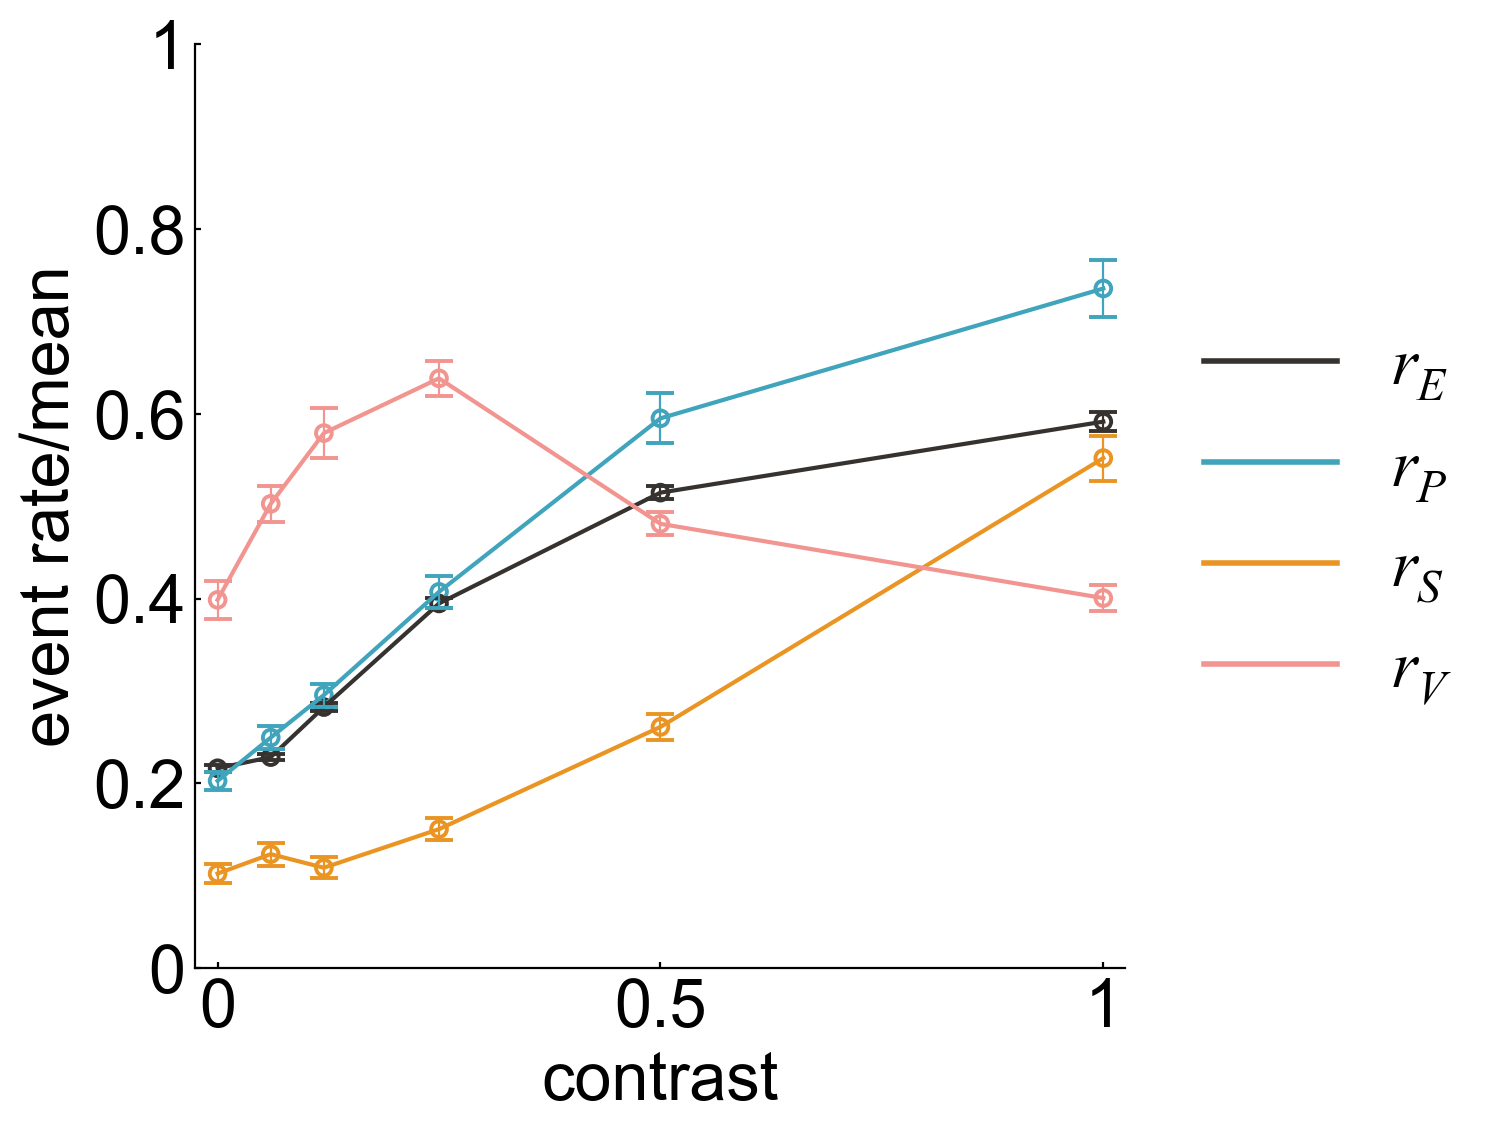

In [87]:
# visualise data

fig = plot_data_EPSV(c_range, means, sems, savefig=False)

### fitting pipeline

In [ ]:
# define fitting parameters

N_fits = 10000 # no params/fits to infer
fit_condition = 1 # fit condition from paper
fit_condition_tol = 1e-5 # tolerance for fit condition
solver_max_iter = 100000
solver_stopping_tol = 1e-8
z_lims = [-10, 50] # limits to search for z
N_z = 100000 # no z samples

# define parameter priors

prior_magnitude_main = pm = 8 # main prior magnitude
prior_magnitude_small = ps = 0.5 # small prior magnitude for W_EV/W_PV
prior_lower_bound = 1e-3 # lbound to prevent 0 values in params
W_prior = np.array([[pm, -pm, -pm, -ps], 
                    [pm, -pm, -pm, -ps], 
                    [pm,   0,   0, -pm], 
                    [pm, -pm, -pm,   0]])
random_prior = False # randomly sample from within bounds (True) or use prior mean (False)

# other consts

TAU = np.diag([0.02, 0.01, 0.01, 0.01]) # time const matrix for jacobian
np.random.seed(0) # set seed (optional)

# filtering options

filter_nan = True # filter out nans (when no fp found)
filter_ISN = True # filter out non-ISN params (f'_E w_EE < 0)
filter_unstable = True # filter out unstable params under no external input

# other options

top_k = 200 # top k params/fits to save
save_to_file = True # save data after fitting
sample_correlated = False # sample surrogate data with correlations across contrasts
verbose = True # verbose outputs


In [ ]:
# step 1: infer parameters

params, errors = infer_params(
    means, covs, c_range, W_prior, fit_condition, N_datapoints,
    N_fits=N_fits, prior_lower_bound=prior_lower_bound,
    fit_condition_tol=fit_condition_tol, solver_stopping_tol=solver_stopping_tol,
    solver_max_iter=solver_max_iter, random_prior=random_prior,
    sample_correlated=sample_correlated, verbose=verbose
)

In [ ]:
# step 2: fit rate models

fits, likelihoods, z_roots_lists = fit_rates(
    params, c_range, means, covs, fit_condition,
    N_fits=N_fits, z_lims=z_lims, N_z=N_z,
    sample_correlated=sample_correlated, verbose=verbose
)

In [ ]:
# step 3: filter fits

filtered_params, filtered_fits, filtered_likelihoods = filter_fits(
    params, fits, likelihoods, c_range, TAU,
    filter_nan=filter_nan, filter_ISN=filter_ISN, 
    filter_unstable=filter_unstable, verbose=verbose
)

In [ ]:
# step 4: sort by likelihood

top_fits, top_params, top_likelihoods = get_top_k_fits(
    filtered_fits, filtered_params, filtered_likelihoods, top_k, fit_condition, save_to_file=save_to_file
)

### plots and analytics

In [ ]:
# load fits/params from file (optional)

with open('../data/fits_cnd1_top200_250102_125616.pkl', 'rb') as f:
    top_fits, top_params, top_likelihoods = pickle.load(f)

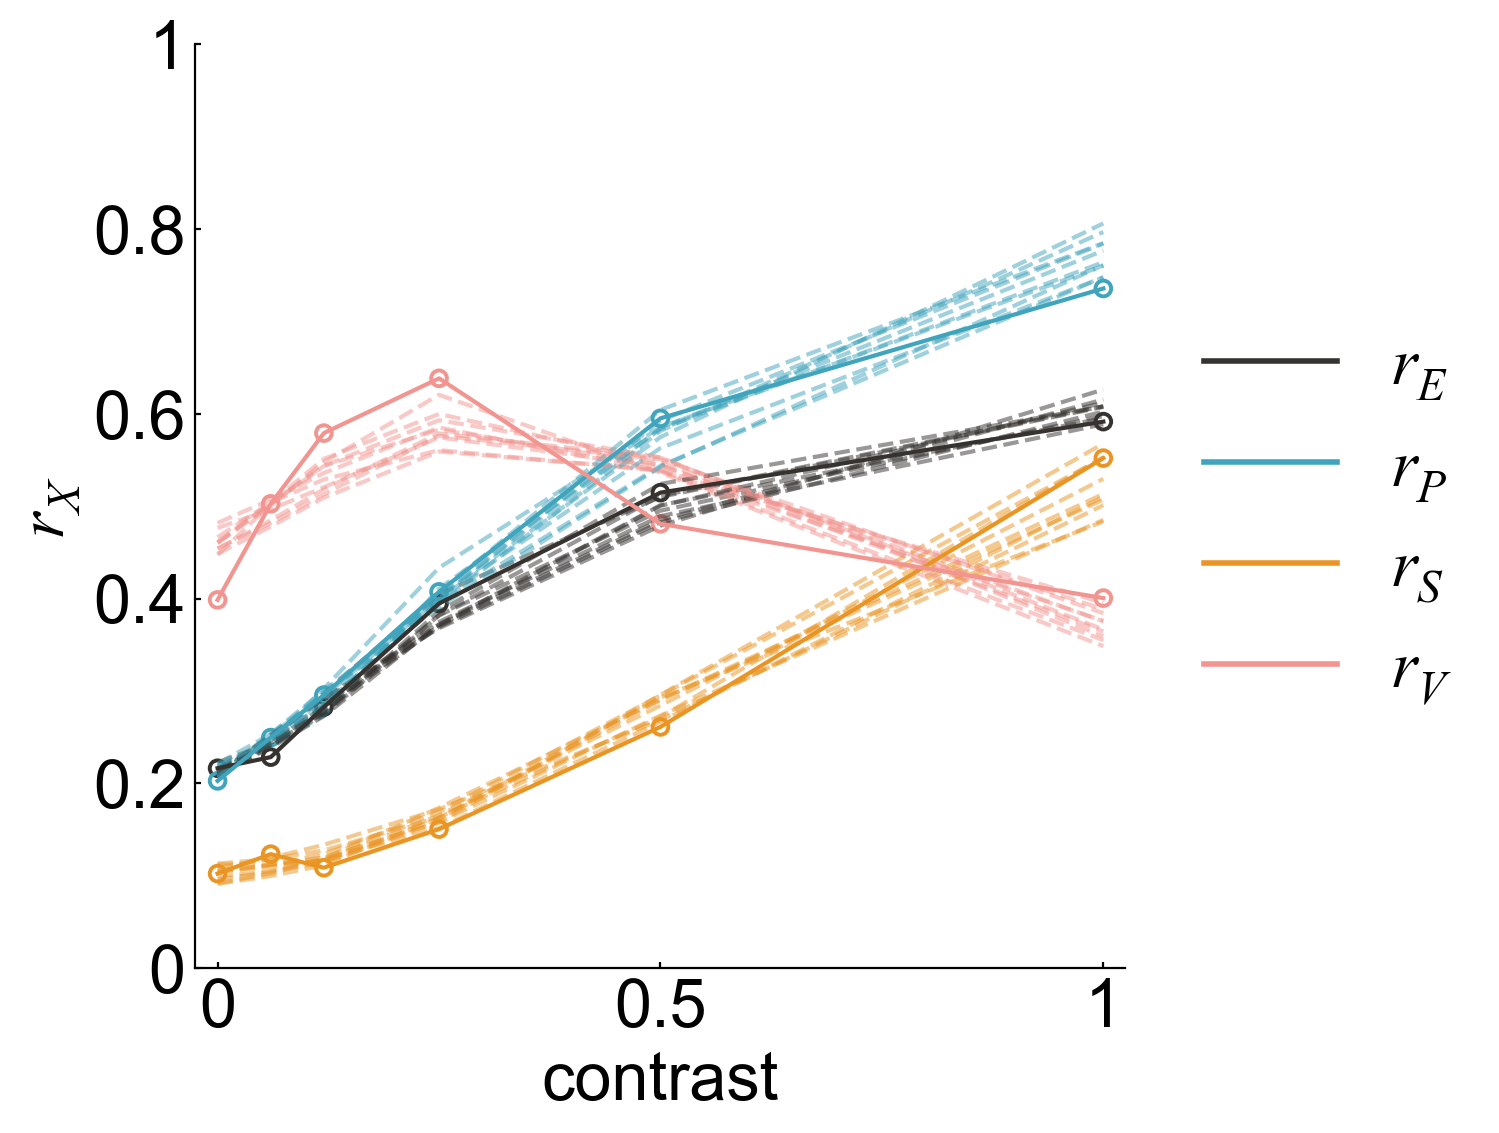

In [99]:
# plot top k fits alongside data

n_plot = 10
fig = plot_data_fits_EPSV(c_range, means, top_fits, n_plot=n_plot, savefig=False)


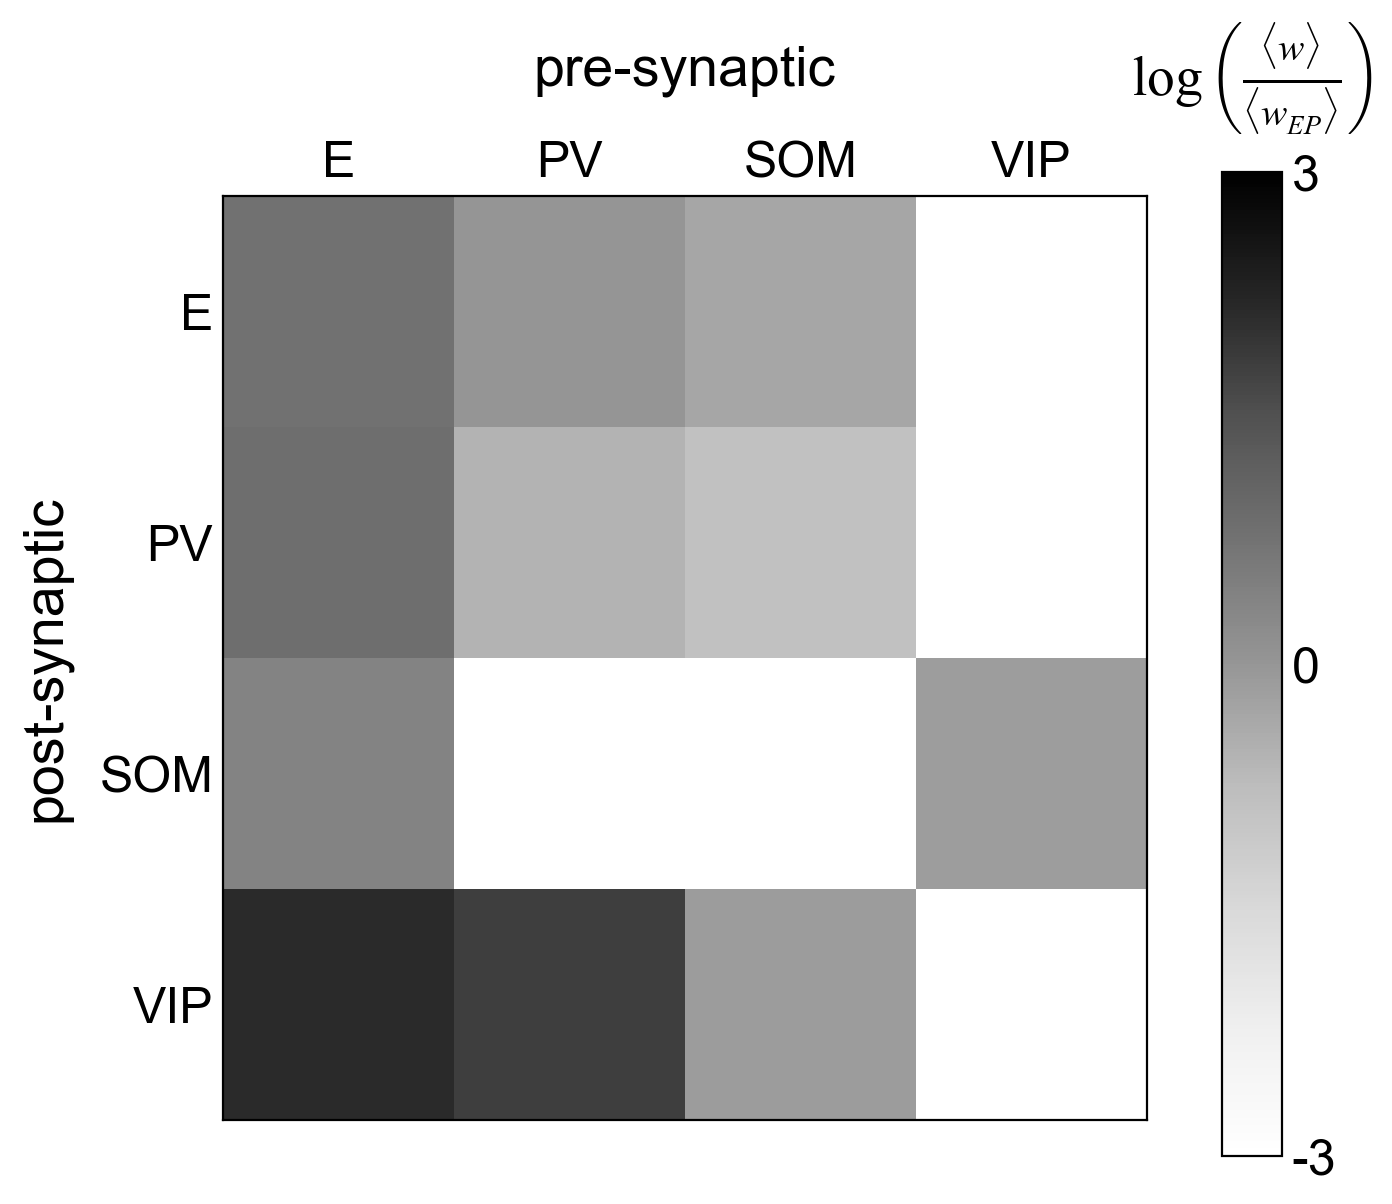

In [107]:
# plot heatmap for single W

k = 1 # 30
W = top_params[k][0]

fig = plot_W_heatmap(W, k, savefig=False)


/Users/lukej/Documents/Gatsby/code/scripts_new/plotting_functions.py:257: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


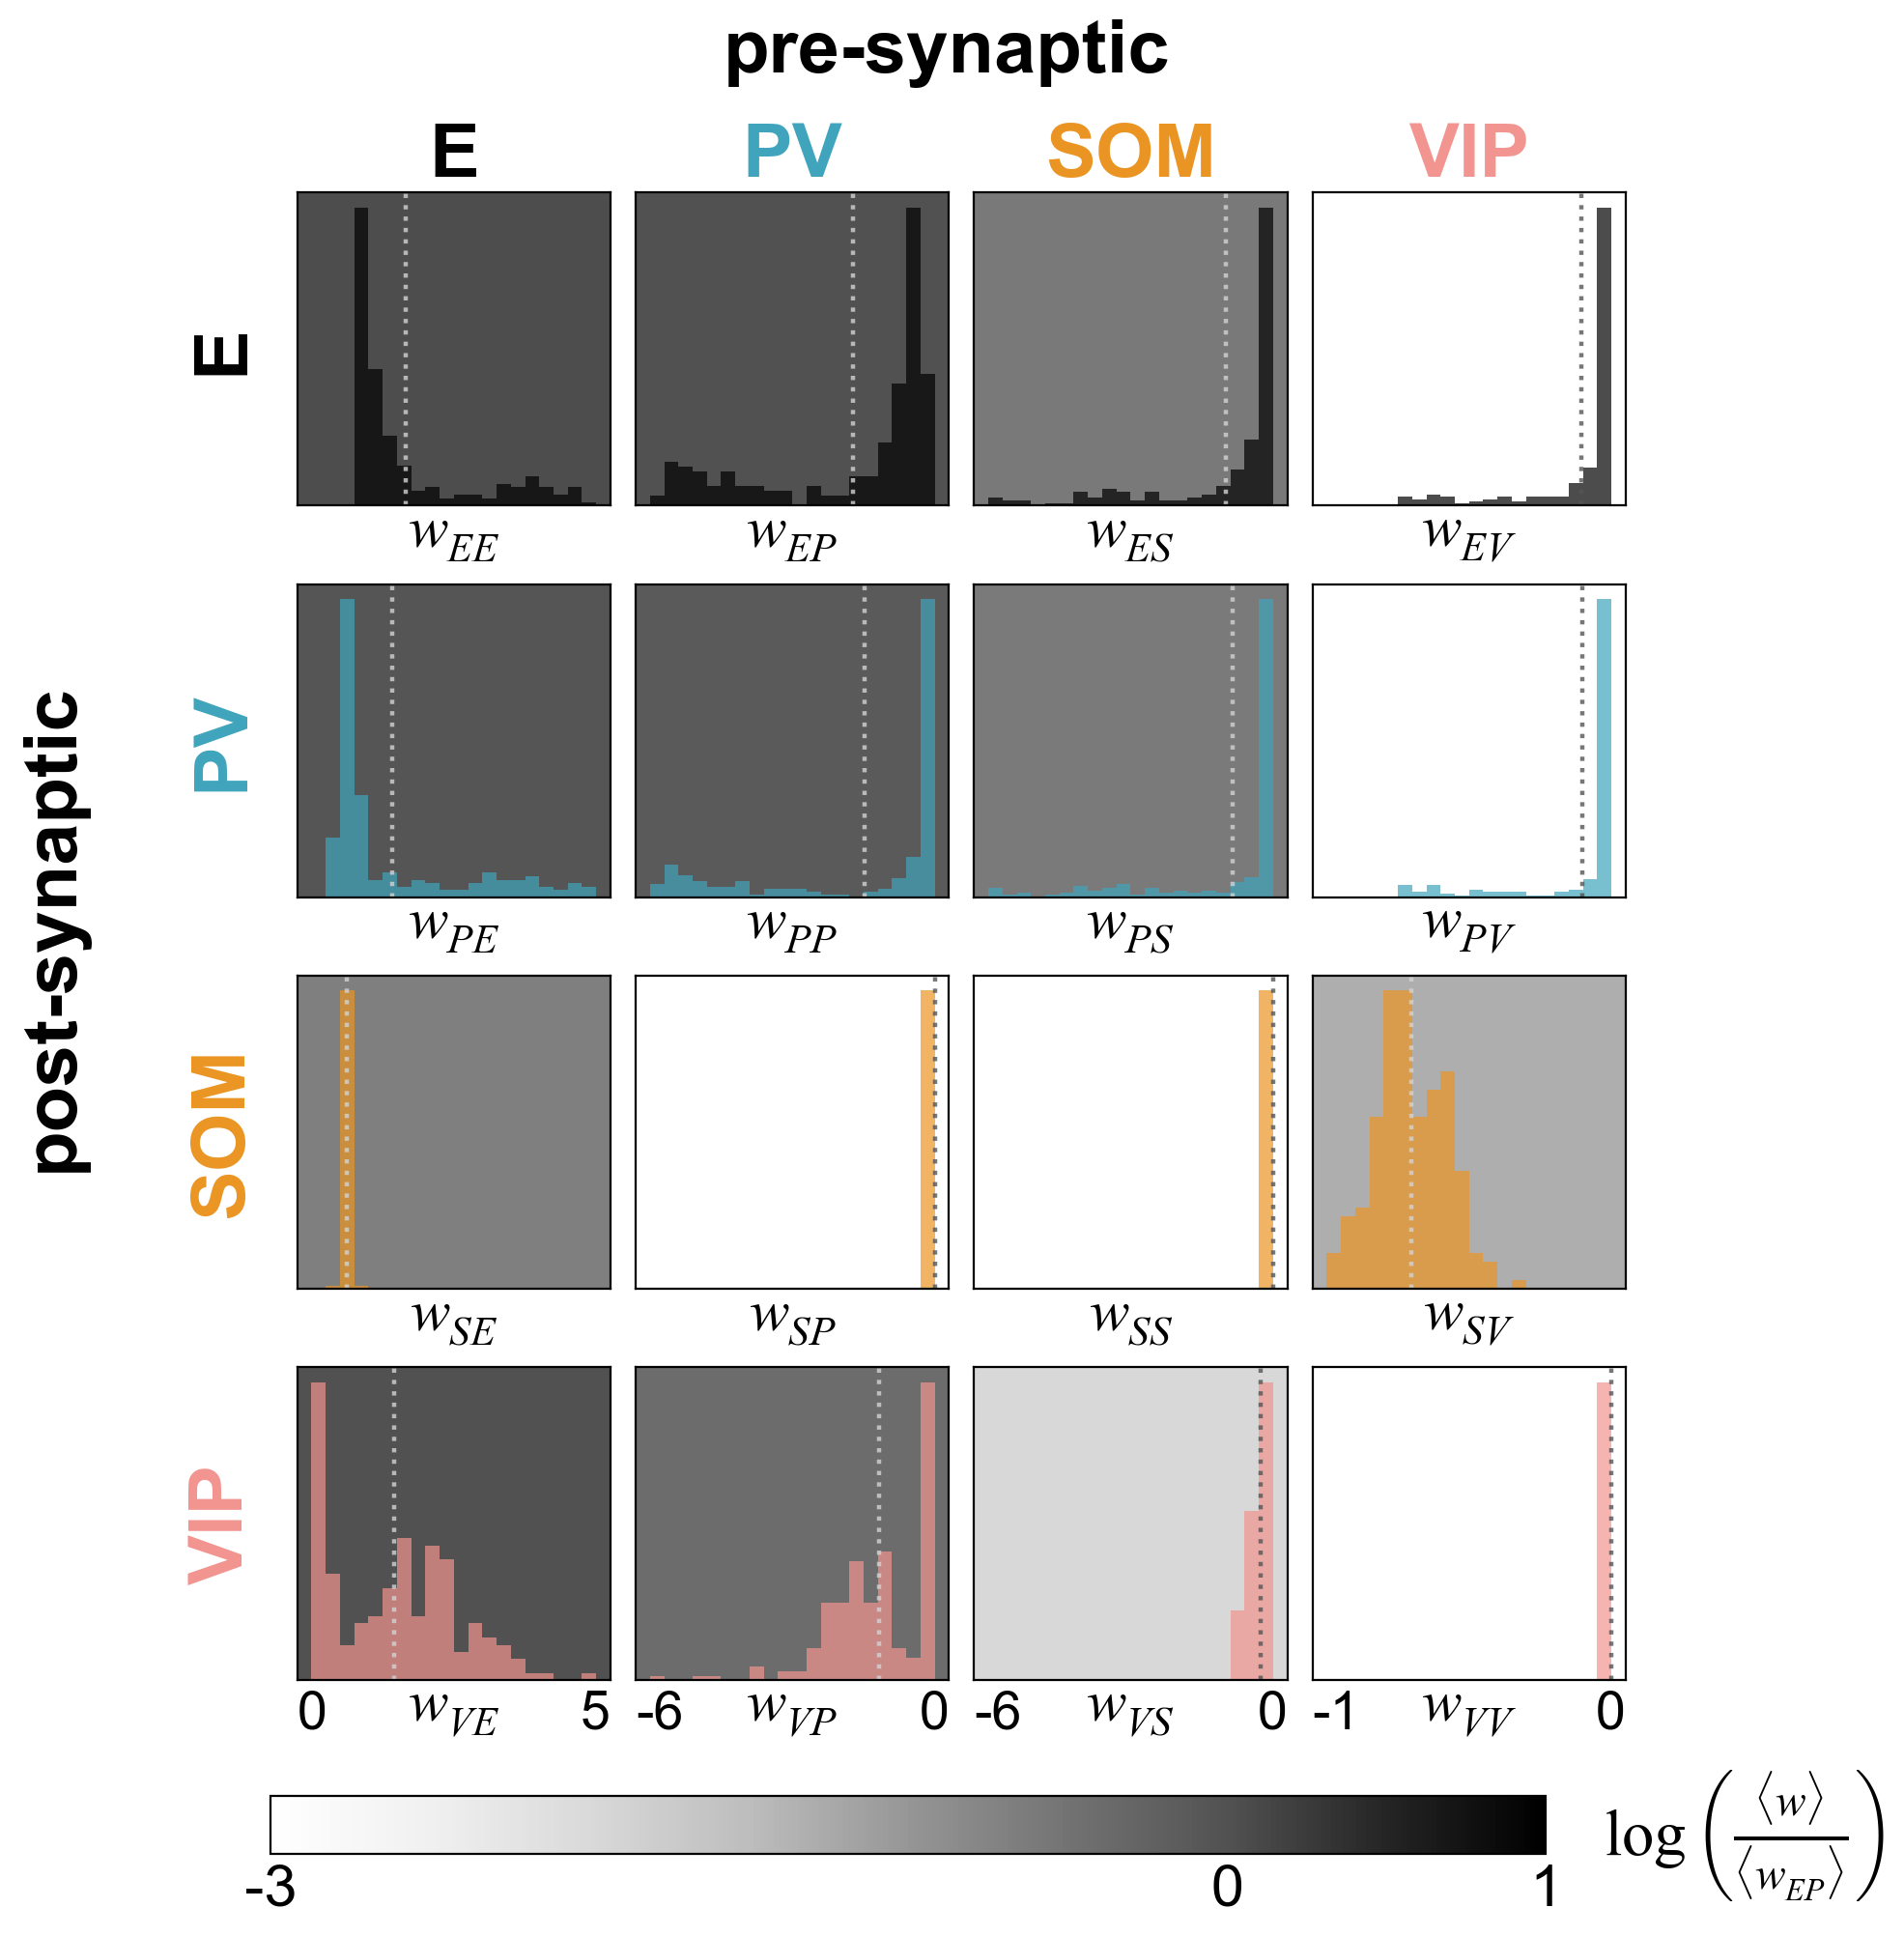

In [112]:
# plot heatmap/histograms across top W

bins = 20

fig = plot_W_hists_all(top_params, bins, lower_lim=-3, percentiles=[1,99], savefig=False)


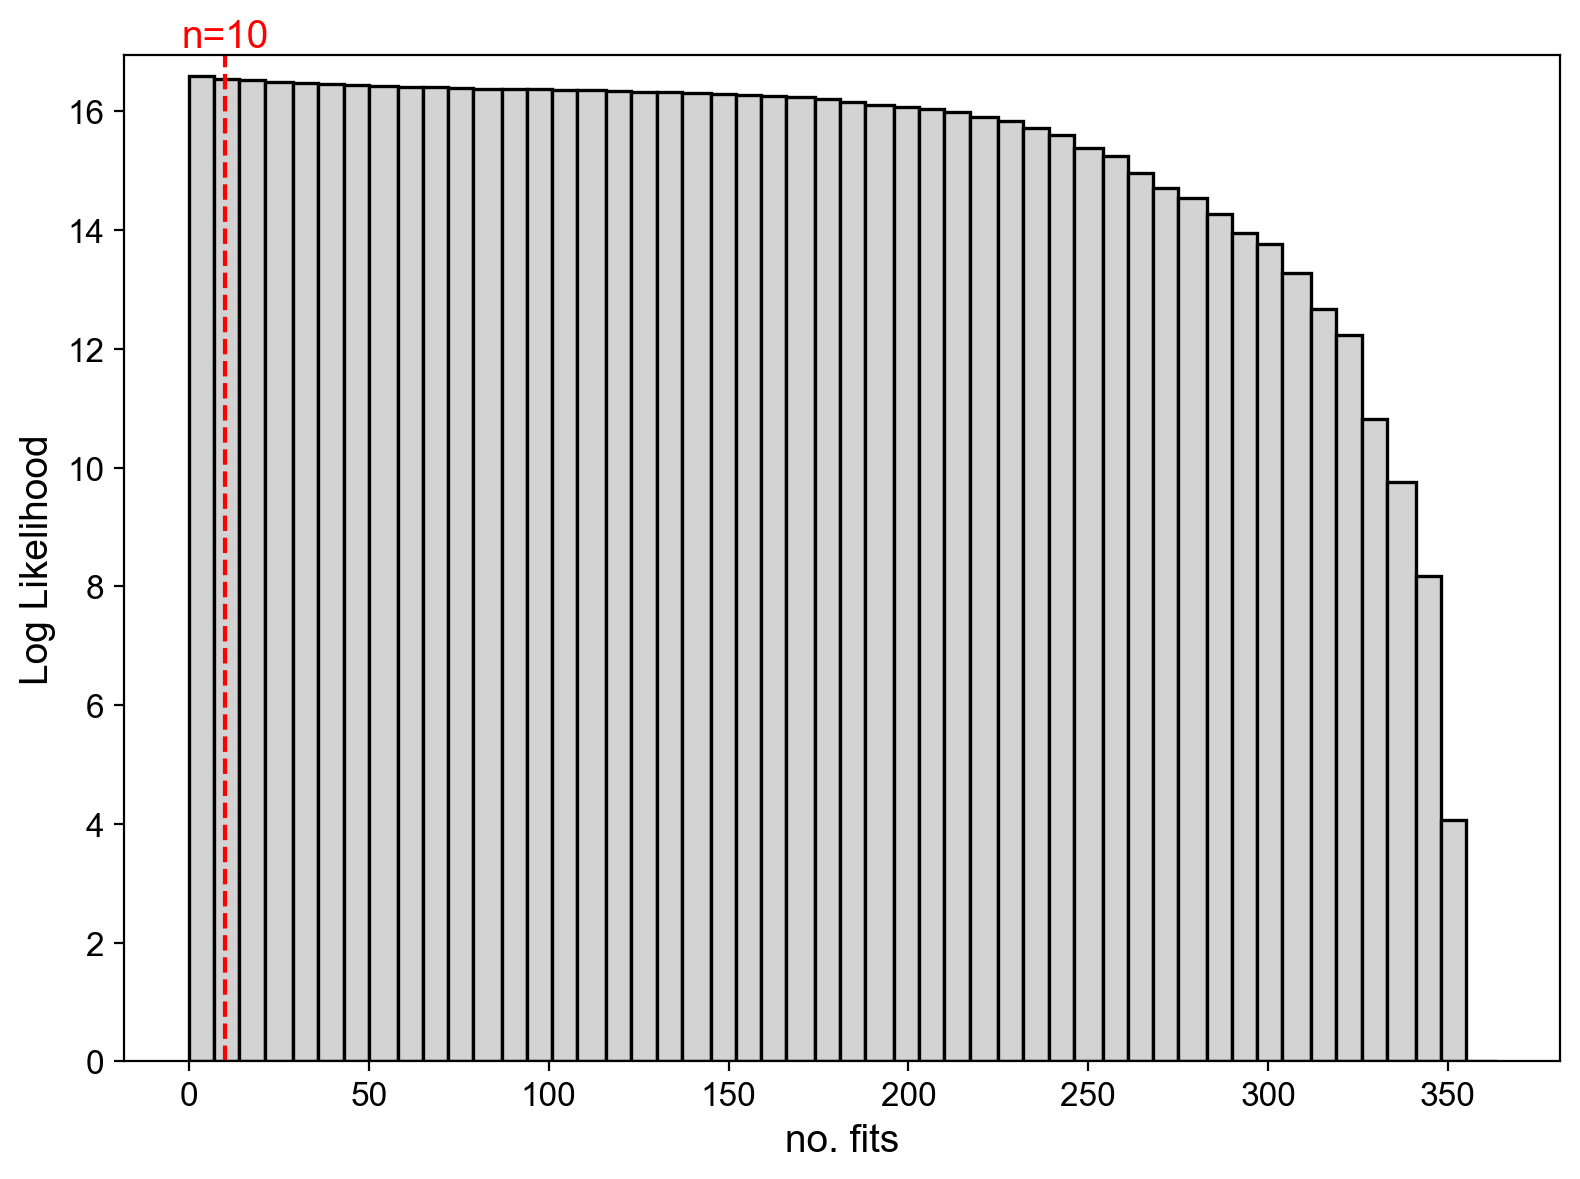

In [125]:
# plot likelihoods hist

top_k_label = 10
bins = 50

fig = plot_top_likelihoods(filtered_likelihoods, top_k_label, bins, proportion=1, savefig=False) # filtered_likelihoods


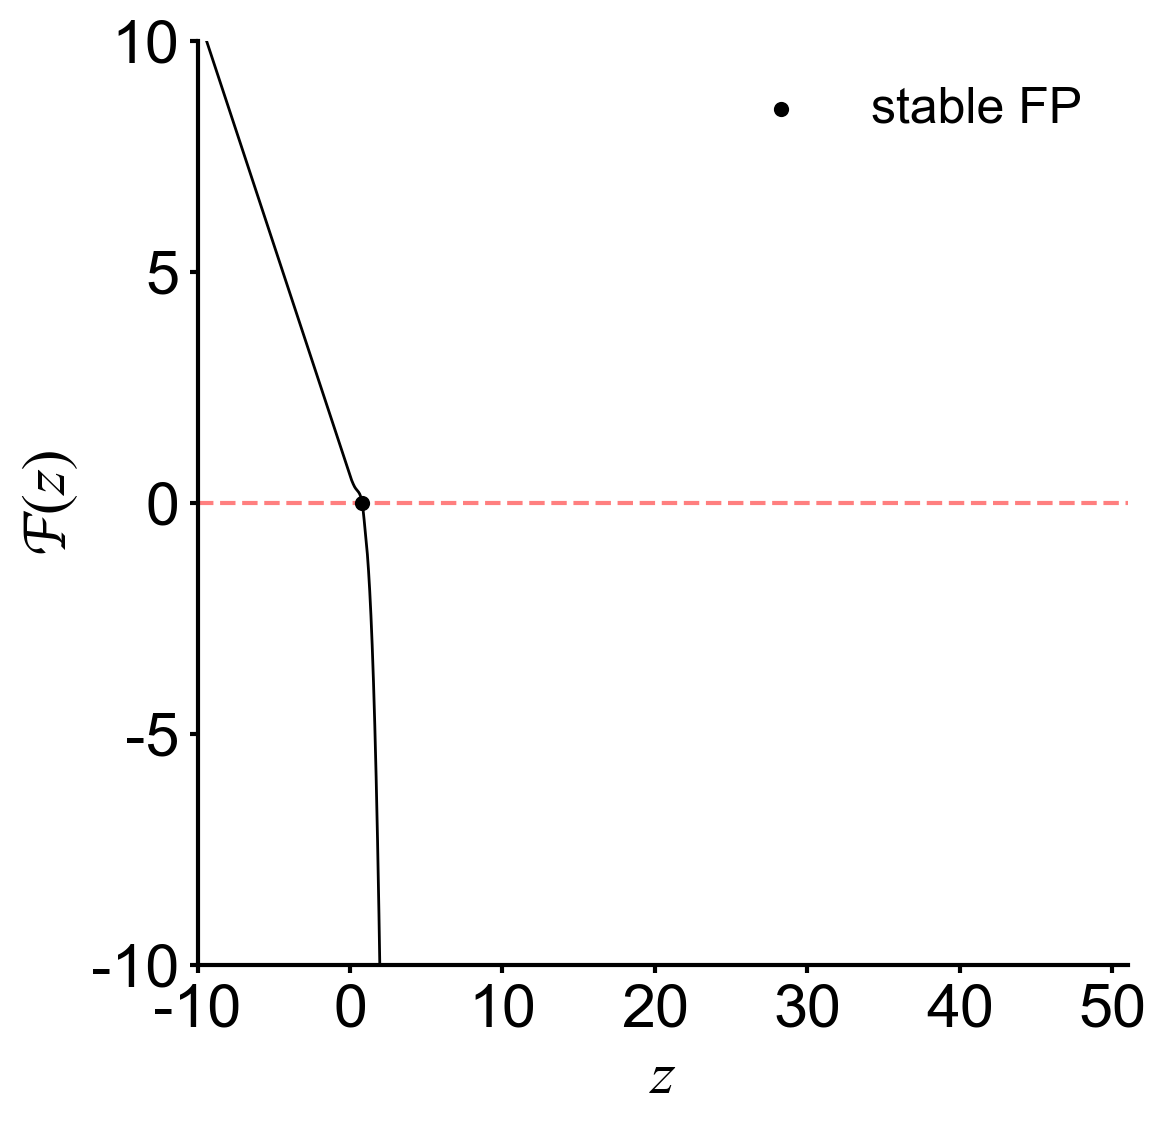

In [126]:
# plot polynomial for single param set, contrast

k = 1 # 27 
contrast = 1
fit_condition = 1
plot_params = top_params[k] # filtered_params[k] # top_params[k] # params[k]
W, h1, h0 = plot_params
h_ext = np.array([0, 0, 0, 0])
h0_tot = h0 + h_ext
plot_params = (W, h1, h0_tot)
N_z = int(1e6)
z_lims = [-10, 50]
y_lims = [-10, 10]

fig, _, _ = plot_polynomial(plot_params, c_range, means, contrast, h_ext, TAU, k, z_lims=z_lims, y_lims=y_lims, fit_condition=fit_condition, N_z=N_z, savefig=False)


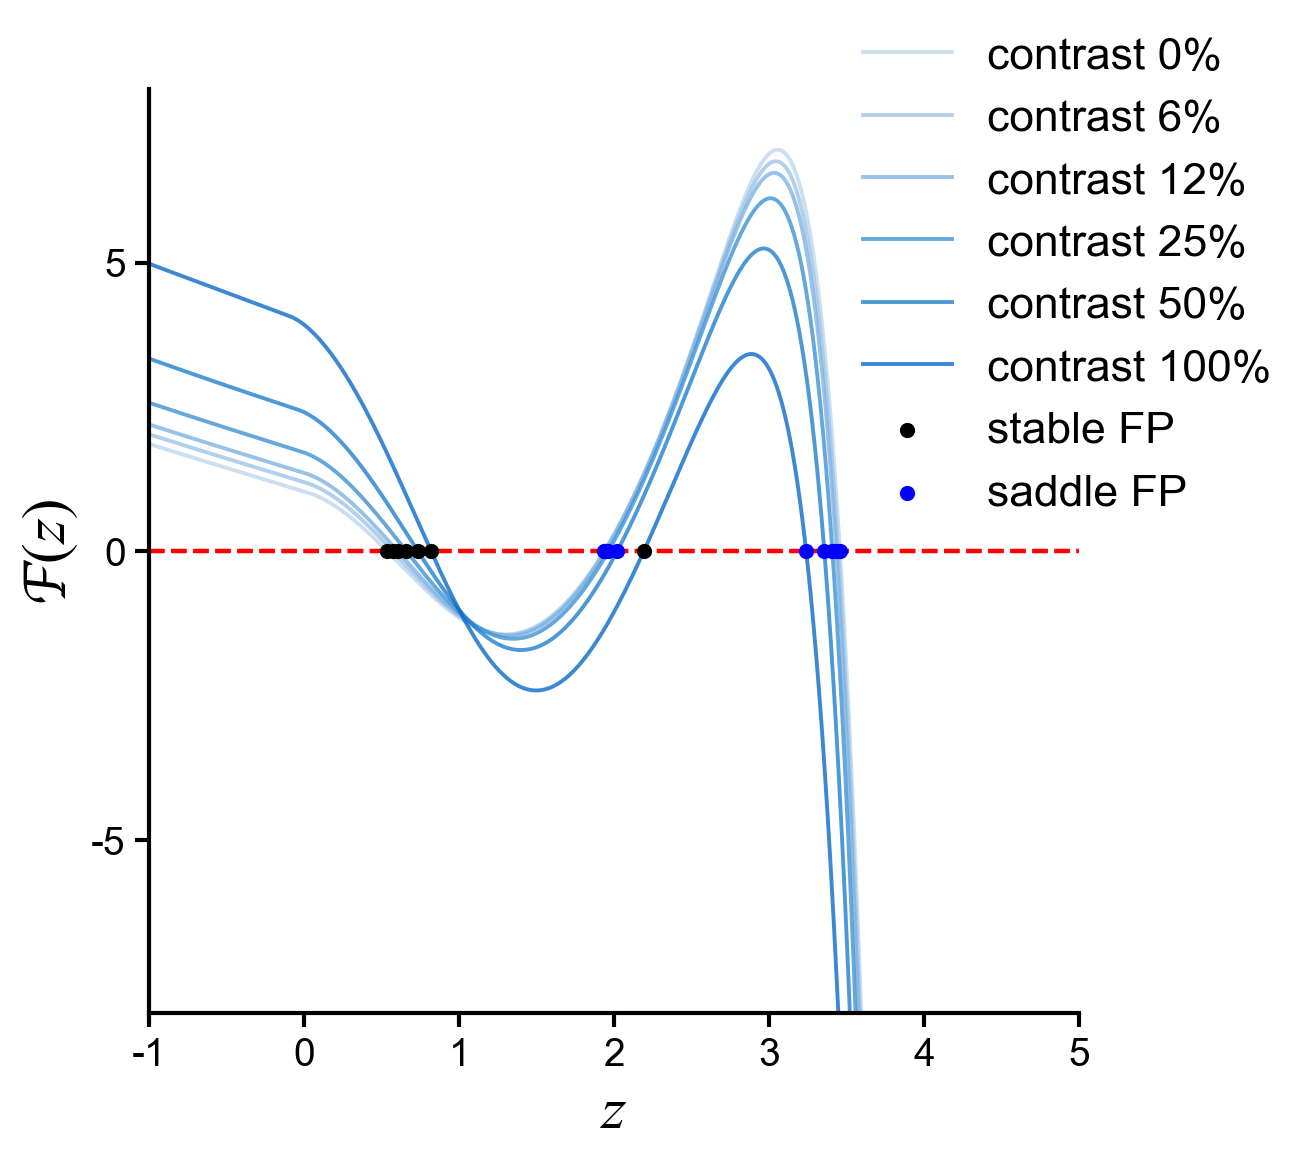

In [145]:
# plot poly across contrasts for single param set

k = 1 # 8
fit_condition = 1
plot_params = filtered_params[k] # top_params[k] # params[k] # filtered_params[k]
z_lims = [-1, 4]
y_lims = [-8, 8]

fig = plot_polynomial_c_range(plot_params, c_range, means, h_ext, TAU, k, z_lims=z_lims, y_lims=y_lims, N_z=N_z, fit_condition=fit_condition, savefig=False)


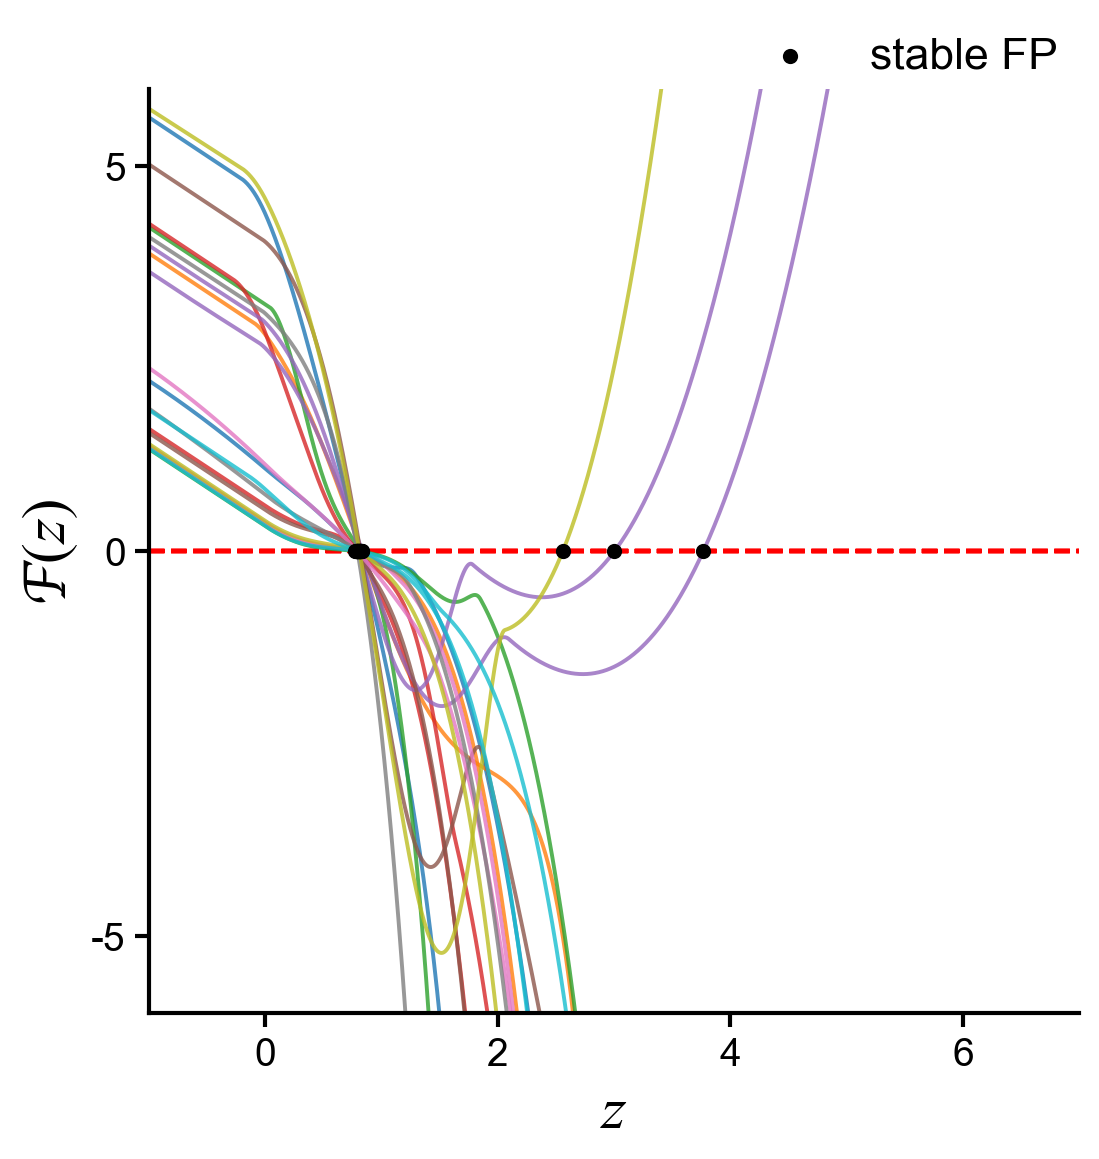

In [ ]:
# plot poly across param sets for single contrast

contrast = 1
n_plots = 20
indices = np.random.randint(0, len(top_params), n_plots)
params_list = [top_params[i] for i in indices]
fit_condition = 1
plot_params = filtered_params[k] # top_params[k] # params[k] # filtered_params[k]
z_lims = [-1, 6]
y_lims = [-6, 6]

fig = plot_polynomial_multiple_fits(indices, params_list, c_range, means, h_ext, contrast, TAU, z_lims=z_lims, y_lims=y_lims, fit_condition=1, savefig=False)


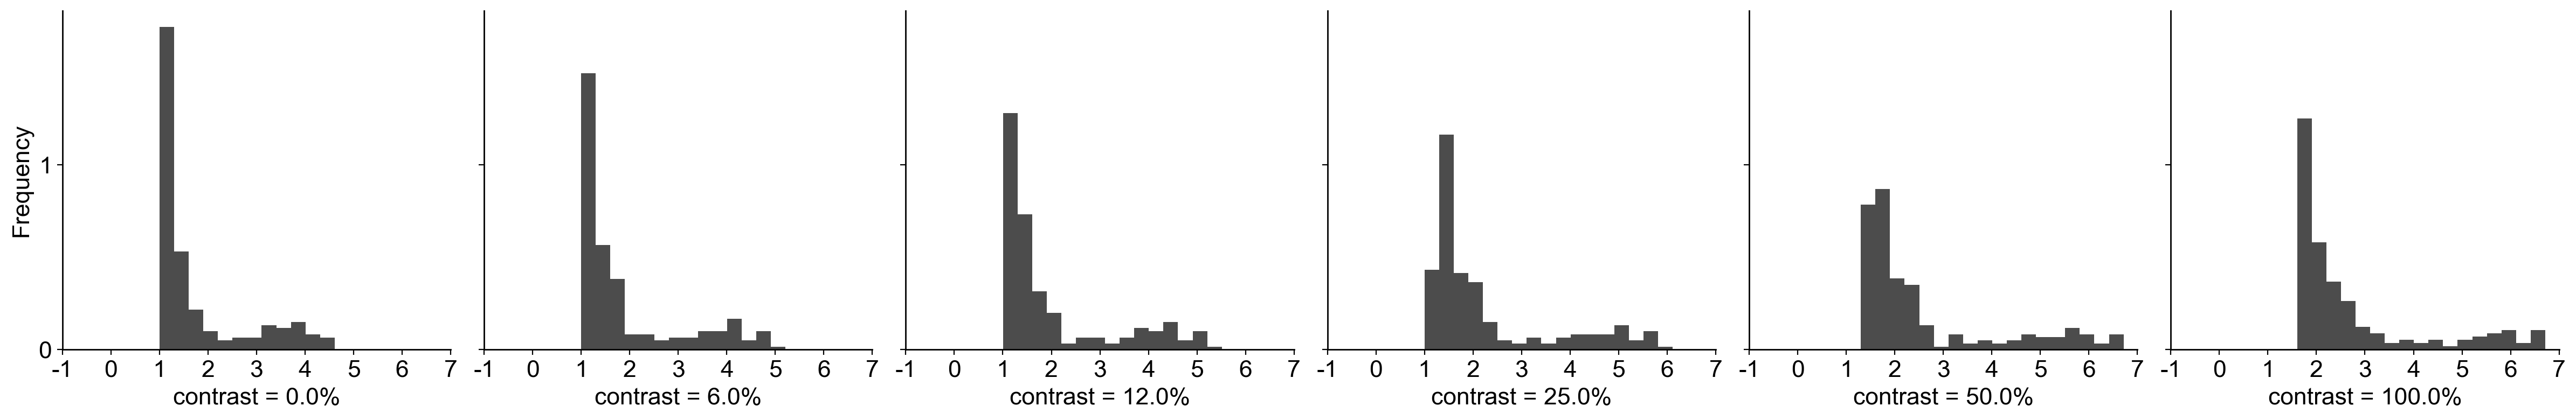

In [139]:
# plot ISN coeffs dist

fig = plot_ISN_hists(top_params, c_range, top_fits, bins=20, savefig=False)
